In [1]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt 
import time
import numpy as np
import re
import random
import operator

from collections import Counter
from collections import defaultdict
from adjustText import adjust_text
from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from IPython.display import HTML
from mpl_toolkits import mplot3d

%matplotlib inline 

In [126]:
def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive',
          'tab:cyan', 'darkslateblue', 'cornflowerblue', 'mediumspringgreen', 'burlywood', 'aqua', 'goldenrod', 'teal', 
          'lightcoral', 'mediumslateblue']

hide_toggle()

# Crunchbase Data of All Blockchain Companies
Scraped 7892 companies that include any of the following keywords under the Industries column: Blockchain, Bitcoin, Cryptocurrency, Ethereum

In [3]:
df = pd.read_csv('crunchbase_data/crunchbase_blockchain_companies.csv', encoding='utf-8')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 50) # Show full text
df

,Organization Name,Headquarters Location,Headquarters Regions,Estimated Revenue Range,Description,Operating Status,Founded Date,Exit Date,Closed Date,Company Type,Website,Twitter,Facebook,LinkedIn,Contact Email,Phone Number,Number of Articles,Full Description,Hub Tags,Investor Type,Investment Stage,Number of Portfolio Organizations,Number of Investments,Number of Lead Investments,Number of Exits,Number of Exits (IPO),Accelerator Application Deadline,Accelerator Duration (in weeks),Accelerator Program Type,School Type,School Program,Number of Enrollments,School Method,Number of Founders (Alumni),Number of Alumni,Industry Groups,Industries,Number of Founders,Founders,Number of Employees,Number of Funding Rounds,Funding Status,Last Funding Date,Last Funding Amount,Last Funding Type,Last Equity Funding Amount,Last Equity Funding Type,Total Equity Funding Amount,Total Funding Amount,Top 5 Investors,Number of Lead Investors,Number of Investors,Acquisition Status,Number of Acquisitions,Transaction Name,Acquired by,Announced Date,Price,Acquisition Type,Acquisition Terms,IPO Status,IPO Date,Delisted Date,Valuation at IPO,Money Raised at IPO,Stock Symbol,Stock Exchange,Number of Events,CB Rank (Organization),CB Rank (Company),CB Rank (School),Trend Score (7 Days),Trend Score (30 Days),Trend Score (90 Days),Monthly Visits,Average Visits (6 months),Monthly Visits Growth,Visit Duration,Visit Duration Growth,Page Views / Visit,Page Views / Visit Growth,Bounce Rate,Bounce Rate Growth,Global Traffic Rank,Monthly Rank Change (#),Monthly Rank Growth,Active Tech Count,Number of Apps,Downloads Last 30 Days,Total Products Active,Most Popular Trademark Class,IT Spend,Most Recent Valuation Range,Date of Most Recent Valuation
0,Kraken,"San Francisco, California, United States","San Francisco Bay Area, West Coast, Western US",$50M to $100M,Kraken is a cryptocurrency exchange that provi...,Active,"Jul 28, 2011",—,—,For Profit,www.kraken.com/,View on Twitter,View on Facebook,View on LinkedIn,support@kraken.com,—,45,Our mission is to accelerate the adoption of c...,Unicorn,—,—,—,—,—,—,—,—,—,—,—,—,—,—,—,—,"Financial Services, Lending and Investments, P...","Asset Management, Blockchain, Cryptocurrency, ...",1,Jesse Powell,501-1000,4,—,"May 21, 2019","$13,500,000",Equity Crowdfunding,"$13,500,000",Equity Crowdfunding,"$118,500,000","$118,500,000","Blockchain Capital, BnkToTheFuture, Digital Cu...",1,6,Made Acquisitions,10,—,—,—,—,—,—,Private,—,—,—,—,—,—,2,68,57,—,-1.1,-2.5,9.0,"2,737,958","3,119,818.28",-3.16%,539,-5.4%,6.66,-4.78%,37.37%,3.08%,"18,642","1,514",8.84%,—,—,—,19,Insurance; financial affairs,"$163,179",—,—
1,Circle,"Boston, Massachusetts, United States","Greater Boston Area, East Coast, New England",$10M to $50M,"Circle is a global internet finance company, b...",Active,2013,—,—,For Profit,www.circle.com/en/,View on Twitter,View on Facebook,View on LinkedIn,info@circle.com,—,186,Circle provides an online platform that enable...,Unicorn,—,—,—,—,—,—,—,—,—,—,—,—,—,—,—,—,"Financial Services, Lending and Investments, P...","Banking, Blockchain, Cryptocurrency, Finance, ...",2,"Jeremy Allaire, Sean Neville",251-500,7,—,"Aug 30, 2018",—,Secondary Market,—,Undisclosed,"$246,000,000","$246,000,000","Blockchain Capital, General Catalyst, Bitmain,...",4,27,Made Acquisitions,3,—,—,—,—,—,—,Private,—,—,—,—,—,—,10,298,275,—,5.9,4.2,2.0,"235,837","229,511.6",-23.43%,338,22.19%,6.65,10.55%,45.13%,-1.41%,"133,921","23,691",21.49%,47,4,"2,364",13,—,—,$1B to $10B,"May 16, 2018"
2,Ripple,"San Francisco, California, United States","San Francisco Bay Area, West Coast, Western US",$10M to $50M,Ripple provides one frictionless experience to...,Active,2012,—,—,For Profit,ripple.com,View on Twitter,View on Facebook,View on LinkedIn,info@ripple.com,—,987,Ripple provides one frictionless experience to...,Unicorn,—,—,9,11,4,1,1,—,—,—,—,—,—,—,—,—,"Financial Services, Internet Services, Payment...","Blockchain, Cryptocurrency, Financial Services...",3,"Arthur Britto, Chris L

### Compare Crunchbase Data to Master List
Currently, the data includes 69 out of 111 startups in the master list. The startups not found do not have Blockchain, Bitcoin, Cryptocurrency, or Ethereum in the Industries column on crunchbase.


In [4]:
# Check that certain startup names exist
names_in_df = [name.lower().strip() for name in df['Organization Name'].tolist()]

# Check startups on the Master List
masterlist_startups = None
with open('masterlist_data/blockchain_startup_names.txt', 'r') as f:
    masterlist_startups = [line.lower().strip() for line in f]
    
found = []
diff_name = []
not_found = []
for name in masterlist_startups:
    #if name in names_in_df:
    found_names = [elem for elem in names_in_df if name in elem.split(' ')]  
    if any(name in x for x in names_in_df):
        if found_names and (len(found_names) > 1 and found_names[0] != name):
            diff_name.append((name, found_names))
        else:
            found.append(name)
    else:
        not_found.append(name)
        
print('%d out of %d companies found in master list:' % (len(found), len(masterlist_startups)))
print(found)
print('\n%d may be under a different name:' % len(diff_name))
print(diff_name)
print('\nnot found:')
print(not_found)
hide_toggle()

64 out of 111 companies found in master list:
['abra', 'aeternity', 'alphapoint', 'airfox', 'ardor', 'ascribe', 'augur', 'backfeed', 'bigchaindb', 'bitfury', 'bitmark', 'bitpay', 'bitse', 'blockmedx', 'blockstream', 'bloq', 'cashaa', 'chain inc.', 'chain of things', 'chainy', 'circle', 'coinbase', 'colu', 'connectjob', 'crowdz', 'cypherium', 'decent', 'dfinity', 'epiphyte', 'filecoin', 'global blockchain', 'herosphere', 'hive blockchain', 'horizon state', 'humaniq', 'hyperledger', 'icobox', 'komodo', 'latoken', 'lisk', 'loci', 'luna', 'minthealth', 'monax', 'odem', 'omisego', 'openbazaar', 'openchain', 'parity technologies', 'peercoin', 'plex', 'propy', 'provenance', 'riot', 'ripio', 'ripple', 'sensay', 'shipchain', 'simplex', 'tenx', 'trusttoken', 'vechain', 'veem', 'xapo']

5 may be under a different name:
[('ark', ['ark ecosystem, scic (ark.io)', 'ark fund']), ('colony', ['honeycomb colony', 'colony']), ('ethereum', ['ethereum foundation', 'ethereum labs', 'ethereum classic labs']),

### Helper Functions for plotting data

In [5]:
# Get all words in a column
def get_column_words(df, column_name, year=None):
    if year:
        df = df[df['Founded Year'] == year]
    words_list = []
    for words in df[column_name].tolist():
        words = list(map(str.strip, words.split(',')))
        words = list(filter(lambda x: x != '—', words))
        words_list.extend(words)
    return words_list

# Get all unique words in a column
def get_column_words_unique(df, column_name, year=None):
    words_list = get_column_words(df, column_name, year=None)
    unique_words_list = sorted(list(set(words_list)))
    return unique_words_list

def get_column_words_with_counts(df, column_name, year=None):
    words_list = get_column_words(df, column_name, year)
    return list_to_dict(words_list)

# Convert list to dictionary where key is the element and value is the count
def list_to_dict(list_item, vocab=None):
    if vocab:
        words_count_dict = dict.fromkeys(vocab,0)
        for word in list_item:
            words_count_dict[word] += 1
        return words_count_dict
    return Counter(list_item)

# Shows word cloud given a list of words (just for fun)
def show_word_cloud(words_list, title=''):
    words_count_dict = list_to_dict(words_list)
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white',
                    min_font_size = 10)
    wordcloud.generate_from_frequencies(words_count_dict)
                    
    plt.figure(figsize = (3, 3), facecolor = None)
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    if title != '':
        plt.title(title)
    plt.show()

# Creates histogram of frequency of words given a list of words
def create_histogram(hist_data, title='', savepath='', max_y=None, show=True, log=False, xlabel='', ylabel=''):
    """Plots a histogram given a dictionary of keys and values, for x and y axis respectively

    Parameters
    ----------
    hist_data : dict
        A dictionary that contains histogram x values as keys and histogram y values as values
    title : str
        Title of the histogram plot
    savepath : str
        The path where the plot will be saved
    max_y : int
        The maximum y value for the plot
    show : bool
        If True, will show histogram as output
    log : bool
        If True, plots in logarithmic scale. If False, plots in linear scale
    ylabel : str
        The y label for the plot
    """
    plt.ioff()
    fig = plt.figure(figsize = (10, 10), facecolor = None);
    if title != '':
        plt.title(title);
    plt.bar(list(hist_data.keys()), hist_data.values(), color='g');
    plt.xticks(rotation='vertical');
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.yscale('linear')
    min_y = 0
    if log:
        plt.yscale('log')
        max_y = np.log(max_y)
        min_y = 1
    if max_y:
        plt.ylim((min_y, max_y));
    plt.tight_layout();
    if savepath != '':
        plt.savefig(savepath);
        plt.close(fig)
        #print('histogram saved: %s' % savepath)
    if show:
        plt.show()
        
def get_max_word_count(df, column_name, year=None):
    all_words = get_column_words_with_counts(df, column_name, year=year)
    return all_words.most_common(1)[0][1]

# Get histogram data as a dict where keys include all words in vocabulary and values are the counts
def get_words_count_dict(words_list, vocab):
    words_count_dict = list_to_dict(words_list, vocab)
    words_count_dict = dict(sorted(words_count_dict.items(), key=lambda x: x[0]))
    return words_count_dict

def clean_dollar_format(x):
    if '—' in x:
        return 0
    multiplier = 1
    x = x.replace(',', '')
    if '€' in x:
        multiplier = 1.10
    elif '¥' in x:
        multiplier = 0.0092
    elif '£' in x:
        multiplier = 1.29
    x = re.sub(r'[A-Z]+', '', x, re.I)
    x = int(x[1:])
    x = x * multiplier
    return x

def get_word_and_sum_hist_data(df, x_column_name, y_column_name, divisor=1, year=None):
    """Returns dictionary where keys are unique words in a column and values are the sum of numbers in a column
    for that word. For example, keys can be the unique Industry Groups and values can be the sum of Total Funding Amounts
    of the companies for each Industry Group.

    Parameters
    ----------
    df : DataFrame
        The dataframe containing all the data
    x_column_name : str
        The name of the column where its unique words will populate the x values
    y_column_name : str
        The name of the column containing numbers which will be summed up to populate the y values
    divisor : int
        The number to divide the y values by
    year : str
        The year to filter the dataframe by

    Returns
    -------
    dict
        a dictionary that can be passed into the create_histogram function
    """
    max_value = 0
    categories = get_column_words_unique(df, x_column_name)
    category_values_dict = dict.fromkeys(categories, 0)
    if year:
        df = df[df['Founded Year'] == year]
    for category in categories:
        value = df[df[x_column_name].str.contains(category)][y_column_name].apply(clean_dollar_format).sum()
        value = value / divisor
        max_value = max(max_value, value)
        category_values_dict[category] += value
    return category_values_dict, max_value

def plot_companies_per_year(dfs_by_year, calc_y_value, title='', xlabel='', ylabel='', log=False):
    """Creates time series plot given dfs that contain data from different years.

    Parameters
    ----------
    dfs_by_year : list
        A list of dataframes with each containing data from a different year
    calc_y_value : function
        The function that determines how y value is calculated for a given df for a year
    title : str
        The title of the time series plot
    xlabel: str
        The x label for the plot
    ylabel: str
        The y label for the plot
    log : bool
        If True, plots in logarithmic scale. If False, plots in linear scale
    """
    x_vals = []
    y_vals = []
    for df in dfs_by_year:
        year = df['Founded Year'].iloc[0]
        x_vals.append(year)
        y_vals.append(calc_y_value(df))
    
    plt.yscale('linear')
    if log:
        plt.yscale('log')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.plot(x_vals, y_vals, '-o')
    plt.show()
    
def plot_companies_per_year_per_category(dfs_by_year, category_group, calc_y_value, title='', xlabel='', ylabel='', log=False):
    """Creates time series plot for different category groups given dfs that contain data from different years.

    Parameters
    ----------
    dfs_by_year : list
        A list of dataframes with each containing data from a different year
    category_group : list
        A str list of names of Industry Groups to include in the plot
    calc_y_value : function
        The function that determines how y value is calculated for a given df for a year
    title : str
        The title of the time series plot
    xlabel: str
        The x label for the plot
    ylabel: str
        The y label for the plot
    log : bool
        If True, plots in logarithmic scale. If False, plots in linear scale
    """
    for group in category_group:
        x_vals = []
        y_vals = []
        for df in dfs_by_year:
            year = df['Founded Year'].iloc[0]

            df = df[df['Industry Groups'].str.contains(group)]

            x_vals.append(year)
            y_vals.append(calc_y_value(df))

        plt.yscale('linear')
        if log:
            plt.yscale('symlog')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.plot(x_vals, y_vals, '-o', label=group)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

def get_top_n_words(df, column_name, n):
    all_words = get_column_words_with_counts(df, column_name)
    top_words = all_words.most_common(n)
    top_words_list = list(zip(*top_words))[0]
    return top_words_list

hide_toggle()

### Append year column to dataframe
Crunchbase Data has a "Founded Date" column that includes full dates for some companies and just the year for others. This code appends a new "Founded Year" column that only includes the years.

In [6]:
BILLION = 1000000000

top_10_categories_list = get_top_n_words(df, 'Industry Groups', 10)
top_5_categories_list = get_top_n_words(df, 'Industry Groups', 5)

pd.options.mode.chained_assignment = None  # default='warn'
founded_years = []
for i in range(len(df)):
    year = df.loc[i, 'Founded Date'].split(' ')[-1].strip()
    if year != '—':
        assert(year[:2] == '20' or year[:2] == '19' or year[:2] == '18')
        assert(len(year) == 4)
        founded_years.append(year)
    else:
        founded_years.append(None)
        
df['Founded Year'] = founded_years

dfs_by_year = []
unique_years = sorted(list(set(filter(None, founded_years))))

# Only count companies founded after 2008 and before 2020
unique_years = list(filter(lambda year: int(year) >= 2008 and int(year) < 2020, unique_years))

for year in unique_years:
    year_df = df[df['Founded Year'] == year]
    
    dfs_by_year.append(year_df)
    
#df = df.drop(columns=['Founded Year'])
    
print('%d years found in data are >= 2008 and < 2020' % len(dfs_by_year))
print('Number of companies in each year:')
for d in dfs_by_year:
    print('%d ' % len(d), end='')
hide_toggle()

12 years found in data are >= 2008 and < 2020
Number of companies in each year:
33 56 74 103 110 342 503 449 677 1941 1609 271 

# Industry Group Visualizations
Code is flexible for creating histograms and time series plots of Crunchbase data.
<br>
<br>
The Current Visualizations use the "Industry Groups" column of the data:
<br>
- Yearly histograms of all blockchain companies by Industry Group (They are not viewable in this notebook but saved to the "images" folder)
<br>
- Yearly temporal aggregate analysis of top 10 blockchain companies by Industry Group
<br>

Crunchbase's List of Industry Groups and Industries within them:
https://support.crunchbase.com/hc/en-us/articles/360043671353-How-are-industries-organized-

## See Crunchbase Industries/Industry Groups Data

In [7]:
industries_df = df[['Organization Name', 'Industries', 'Industry Groups']]
industries_df

,Organization Name,Industries,Industry Groups
0,Kraken,"Asset Management, Blockchain, Cryptocurrency, ...","Financial Services, Lending and Investments, P..."
1,Circle,"Banking, Blockchain, Cryptocurrency, Finance, ...","Financial Services, Lending and Investments, P..."
2,Ripple,"Blockchain, Cryptocurrency, Financial Services...","Financial Services, Internet Services, Payment..."
3,High Fidelity,"Blockchain, Enterprise Software, Hardware, Sof...","Hardware, Software"
4,Elliptic,"Bitcoin, Blockchain, Finance","Financial Services, Payments, Software"
...,...,...,...
7887,Coupon Kittlez,"Bitcoin, Internet, Sports","Financial Services, Internet Services, Payment..."
7888,Los Angeles Community Development Bank,"Bitcoin, Communities, Leisure, Venture Capital","Community and Lifestyle, Financial Services, L..."
7889,Sinopec Finance Co. Ltd.,"Bitcoin, Crowdfunding, Financial Services, Ven...","Financial Services, Lending and Investments, P..."
7890,Vartan National Bank,"Bitcoin, Financial Services, Venture Capital","Financial Services, Lending and Investments, P..."


In [8]:
all_industries = get_column_words_unique(df, 'Industries')
industries_vocab = all_industries
print('Number of Unique Industries: %d\n' % len(all_industries))
print('\n'.join(all_industries))
hide_toggle()

Number of Unique Industries: 567

3D Printing
3D Technology
Accounting
Ad Exchange
Ad Network
Ad Retargeting
Ad Targeting
Adult
Adventure Travel
Advertising
Advertising Platforms
Advice
Aerospace
Affiliate Marketing
AgTech
Agriculture
Air Transportation
Analytics
Android
Angel Investment
App Discovery
App Marketing
Application Performance Management
Application Specific Integrated Circuit (ASIC)
Apps
Architecture
Art
Artificial Intelligence
Asset Management
Assistive Technology
Association
Auctions
Audio
Augmented Reality
Auto Insurance
Automotive
Autonomous Vehicles
B2B
B2C
Bakery
Banking
Beauty
Big Data
Billing
Bioinformatics
Biometrics
Biopharma
Biotechnology
Bitcoin
Blockchain
Blogging Platforms
Brand Marketing
Brewing
Broadcasting
Browser Extensions
Building Maintenance
Building Material
Business Development
Business Information Systems
Business Intelligence
CAD
CRM
Call Center
Cannabis
Car Sharing
Career Planning
Casino
Casual Games
Catering
Cause Marketing
Celebrity
Charity
Civi

## Number of Firms Per Industry Group

In [9]:
xlabel = 'Industry Groups'
ylabel = 'Number of Companies'
save_dir_name = 'NumberOfCompanies'
save_file_name = 'Industry_Groups'
column_name = 'Industry Groups'
def get_max_y_for_year(year):
    return get_max_word_count(df, column_name, year=year)
def get_hist_data(year):
    categories_vocab = get_column_words_unique(df, column_name)
    categories = get_column_words(df, column_name, year=year)
    return get_words_count_dict(categories, categories_vocab)

# Get Max Y value for plotting
max_y = 0
for year in unique_years:
    max_y_for_year = get_max_y_for_year(year)
    max_y = max(max_y, max_y_for_year)

# Plot and save histograms
for year in unique_years:
    hist_data = get_hist_data(year)
    
    savepath = 'images/' + save_dir_name + '/' + save_file_name + '_%s.png' % year
    log_savepath = 'images/' + save_dir_name + '/(log)' + save_file_name + '_%s.png' % year
    
    create_histogram(hist_data, title=year, show=False, xlabel=xlabel, ylabel=ylabel, max_y=max_y, savepath=savepath)
    create_histogram(hist_data, title=year, show=False, xlabel=xlabel, ylabel=ylabel, max_y=max_y, log=True, savepath=log_savepath)
    
print('Histograms saved to: images/' + str(save_dir_name))
hide_toggle()

Histograms saved to: images/NumberOfCompanies


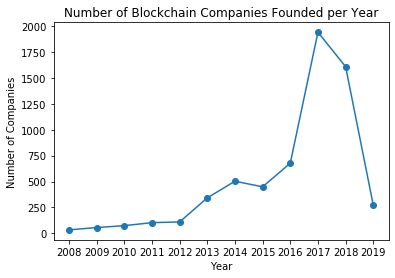

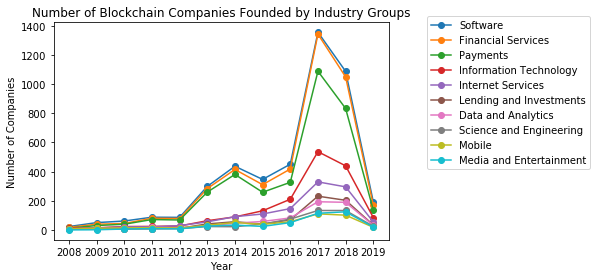

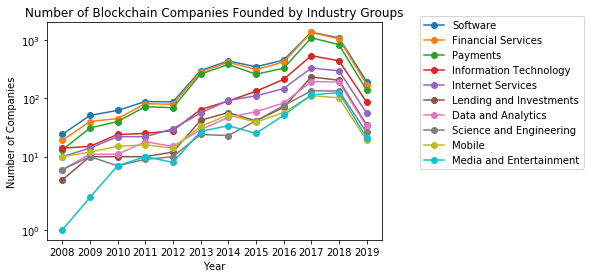

In [10]:
title = 'Number of Blockchain Companies Founded per Year'
xlabel = 'Year'
ylabel = 'Number of Companies'
def calc_y_value(df):
    return len(df)

plot_companies_per_year(dfs_by_year, calc_y_value, xlabel=xlabel, ylabel=ylabel, title=title, log=False)

title = 'Number of Blockchain Companies Founded by Industry Groups'
groups = top_10_categories_list
def calc_y_value(df):
    return len(df)

plot_companies_per_year_per_category(dfs_by_year, groups, calc_y_value, xlabel=xlabel, ylabel=ylabel, log=False, title=title)
plot_companies_per_year_per_category(dfs_by_year, groups, calc_y_value, xlabel=xlabel, ylabel=ylabel, log=True, title=title)
hide_toggle()

## Investments Per Industry Group

In [11]:
xlabel = 'Industry Groups'
ylabel = 'Total Funding Amount (in billions)'
save_dir_name = 'TotalFundingAmount'
save_file_name = 'Investments_By_Industry_Groups'
x_column_name = 'Industry Groups'
y_column_name = 'Total Funding Amount'
divisor = BILLION

def get_max_y_for_year(year):
    _, max_y_for_year = get_word_and_sum_hist_data(df, x_column_name, y_column_name, divisor=divisor, year=year)
    return max_y_for_year
def get_hist_data(year):
    hist_data, _ = get_word_and_sum_hist_data(df, x_column_name, y_column_name, divisor=divisor, year=year)
    return hist_data

# Get Max Y value for plotting
max_y = 0
for year in unique_years:
    max_y_for_year = get_max_y_for_year(year)
    max_y = max(max_y, max_y_for_year)

# Plot and save histograms
for year in unique_years:
    hist_data = get_hist_data(year)
    
    savepath = 'images/' + save_dir_name + '/' + save_file_name + '_%s.png' % year
    log_savepath = 'images/' + save_dir_name + '/(log)' + save_file_name + '_%s.png' % year
    
    create_histogram(hist_data, title=year, show=False, xlabel=xlabel, ylabel=ylabel, max_y=max_y, savepath=savepath)
    create_histogram(hist_data, title=year, show=False, xlabel=xlabel, ylabel=ylabel, max_y=max_y, log=True, savepath=log_savepath)

print('Histograms saved to: images/' + str(save_dir_name))
hide_toggle()

Histograms saved to: images/TotalFundingAmount


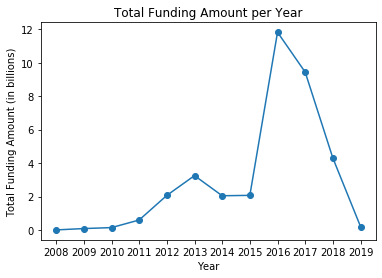

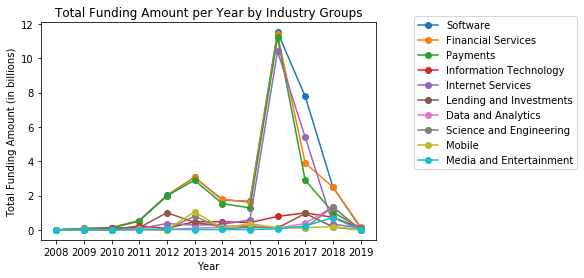

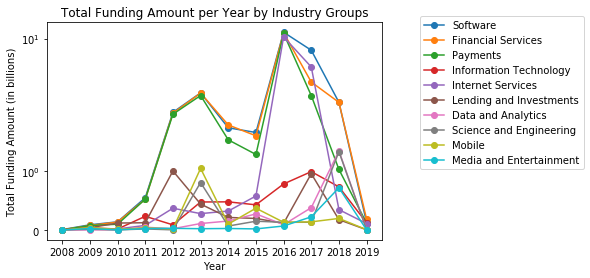

In [12]:
def calc_total_funding_amount(df):
    return df['Total Funding Amount'].apply(clean_dollar_format).sum() / BILLION

title = 'Total Funding Amount per Year'
xlabel = 'Year'
ylabel = 'Total Funding Amount (in billions)'

plot_companies_per_year(dfs_by_year, calc_total_funding_amount, xlabel=xlabel, ylabel=ylabel, title=title, log=False)

title = 'Total Funding Amount per Year by Industry Groups'
groups = top_10_categories_list

plot_companies_per_year_per_category(dfs_by_year, groups, calc_total_funding_amount, xlabel=xlabel, ylabel=ylabel, log=False, title=title)
plot_companies_per_year_per_category(dfs_by_year, groups, calc_total_funding_amount, xlabel=xlabel, ylabel=ylabel, log=True, title=title)
hide_toggle()

## Total Products Active Per Industry Group

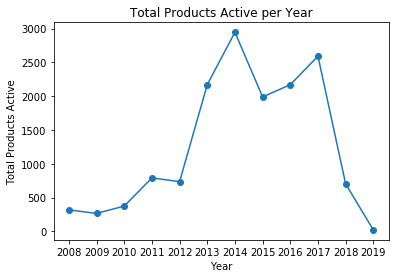

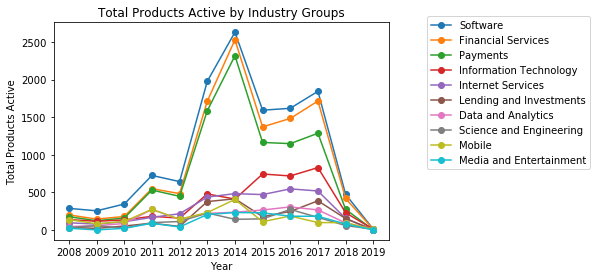

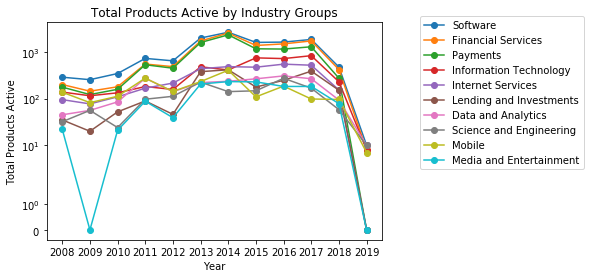

In [13]:
def calc_total_products_active(df):
    return df['Total Products Active'].apply(get_int).sum()

def get_int(x):
    if x == '—':
        return 0
    return int(x)

title = 'Total Products Active per Year'
xlabel = 'Year'
ylabel = 'Total Products Active'

plot_companies_per_year(dfs_by_year, calc_total_products_active, xlabel=xlabel, ylabel=ylabel, title=title, log=False)

title = 'Total Products Active by Industry Groups'
groups = top_10_categories_list

plot_companies_per_year_per_category(dfs_by_year, groups, calc_total_products_active, xlabel=xlabel, ylabel=ylabel, log=False, title=title)
plot_companies_per_year_per_category(dfs_by_year, groups, calc_total_products_active, xlabel=xlabel, ylabel=ylabel, log=True, title=title)
hide_toggle()

# Clustering Visualizations (Using TFIDF Vectors)

In [268]:
def tokenize(txt):
    return txt.split(', ')

def dummy_func(doc):
    return doc

def vectorize(column_name, min_df=0, max_df=float('inf'), chosen_indexes=[]):
    %matplotlib inline
    
    filtered_df = None
    if len(chosen_indexes) > 0:
        filtered_df = df.loc[chosen_indexes]
    else:
        filtered_df = df
    
    documents = filtered_df[column_name].apply(tokenize).tolist()

    vectorizer = TfidfVectorizer(
        analyzer='word',
        tokenizer=dummy_func,
        preprocessor=dummy_func,
        min_df=min_df,
        max_df=max_df,
    )

    document_vectors = vectorizer.fit_transform(documents)
    labels = filtered_df['Organization Name'].tolist()
    return document_vectors, vectorizer, labels

def obtain_word_embeddings(document_vectors, vectorizer):
    df = pd.DataFrame(data=document_vectors.todense(), columns=vectorizer.get_feature_names())
    vecs = []
    for col in df.columns:
        vec = df[col].tolist()
        vecs.append(vec)

    vecs = np.array(vecs)
    labels = df.columns.tolist()
    return vecs, labels
    
def dimensionality_reduction(feat_clips, choice, n_components=2):
    dist = 1 - cosine_similarity(feat_clips)
    standard = StandardScaler().fit_transform(dist)

    mds = None
    if choice == 'TSNE':
        mds = TSNE(n_components=n_components, random_state=1)
    elif choice == 'PCA':
        mds = PCA(n_components=n_components, random_state=1)

    pos = mds.fit_transform(standard)  # shape (n_components,n_samples)

    X = pos
    
    plt.figure(figsize=(8, 5))
    dend = dendrogram(linkage(X, method='ward'),
                        truncate_mode='level',
                        p=8,
                        #orientation='top',
                        #distance_sort='descending',
                        #show_leaf_counts=True
                     )
    
    return X

def cluster(X, n_clusters, labels, title, without_labels=False, width=20, height=20, label_clusters=False, no_overlap=False):    
    cluster_names = defaultdict(str)
    clusters = AgglomerativeClustering(n_clusters=n_clusters).fit_predict(X)
    
    cluster_names = None
    if label_clusters:
        cluster_names = get_top_keywords(document_vectors, clusters, vectorizer.get_feature_names(), 20)

    if X.shape[1] == 2:
        cluster_plot(X, clusters, title, without_labels=without_labels, labels=labels, width=width, height=height, cluster_names=cluster_names, no_overlap=no_overlap)
    elif X.shape[1] == 3:
        cluster_plot_3d(X, clusters, title, without_labels=without_labels, labels=labels, width=width, height=height, cluster_names=cluster_names, no_overlap=no_overlap)

    return clusters
    
def cluster_plot(pos, clusters, title='', without_labels=False, width=20, height=20, labels=None, savepath='', cluster_names=None, no_overlap=False):
    plt.rc('font', size=15)
    
    xs, ys = pos[:, 0], pos[:, 1]
    
    if not labels:
        labels = range(len(documents))

    # Data frame with TSNE data, the cluster numbers and titles
    cluster_df = pd.DataFrame(dict(x=xs, y=ys, clusters=clusters, labels=labels)) 

    fig, ax = plt.subplots(figsize=(width, height))
    ax.margins(0.05)
    ax.set_title(title)

    groups = cluster_df.groupby('clusters')
    for i, (name, group) in enumerate(groups):
        if cluster_names:
            name = cluster_names[name]
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, mec='none', label=name, color=colors[i])
        ax.set_aspect('auto')
        ax.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
        ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')

    ax.legend(numpoints=1)
    ax.legend(bbox_to_anchor=(1.1, 1.05))

    #Add labels
    if not without_labels:
        texts = []
        for i in range(len(cluster_df)):
            texts.append(ax.text(cluster_df.loc[i, 'x'] + 0.01, cluster_df.loc[i, 'y'] + 0.01, cluster_df.loc[i,'labels'], size=10)) 
           
    # This takes too long
    if no_overlap:
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))
    
    if savepath != '':
        plt.savefig(savepath, dpi=200, bbox_inches="tight")

    plt.show()
    
def get_top_keywords(data, clusters, labels, n_terms):
    cluster_names = []
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()

    for i,r in df.iterrows():
        print('Cluster {}'.format(i))

        sorted_industries = []
        for j in np.argsort(r)[::-1]:
            if r[j] > 0:
                sorted_industries.append(labels[j])
                
        print(', '.join(sorted_industries))
        print()
        
        cluster_names.append(', '.join(sorted_industries[:3]))
    return cluster_names

def get_industry_counts_in_clusters(data, clusters, labels, n_terms, width=15, height=10):
    cluster_counts = defaultdict(int)
    
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        sorted_industries = []
        for j in np.argsort(r)[::-1]:
            if r[j] > 0:
                sorted_industries.append(labels[j])
        
        cluster_name = ', '.join(sorted_industries[:3])
        
        cluster_counts[cluster_name] = len([label for label in clusters if label == i])
    
    fig = plt.figure(figsize = (width, height), facecolor = None);
    plt.bar(list(cluster_counts.keys()), cluster_counts.values(), color='b');
    plt.xticks(rotation=45, ha='right')
    plt.title('Frequency of each cluster')
    plt.ylabel('Total frequency of the industry terms in this cluster')
    plt.xlabel('Cluster name (Top 3 words)')
    plt.savefig('clusters_size.png', dpi=200, bbox_inches = 'tight')
    plt.show()
    
def cluster_plot_3d(pos, clusters, title='', without_labels=False, width=20, height=20, labels=None, savepath='', cluster_names=None, no_overlap=False):
    %matplotlib notebook
    plt.rc('font', size=15)
    
    xs, ys, zs = pos[:, 0], pos[:, 1], pos[:, 2]
    
    if not labels:
        labels = range(len(documents))

    # Data frame with TSNE data, the cluster numbers and titles
    cluster_df = pd.DataFrame(dict(x=xs, y=ys, z=zs, clusters=clusters, labels=labels)) 

    fig = plt.figure(figsize = (width, height))
    ax = plt.axes(projection='3d')
    ax.margins(0.05)
    ax.set_title(title)

    groups = cluster_df.groupby('clusters')
    for i, (name, group) in enumerate(groups):
        if cluster_names:
            name = cluster_names[name]
        ax.plot(group.x, group.y, group.z, marker='o', linestyle='', ms=12, mec='none', label=name, color=colors[i])
        ax.set_aspect('auto')
        ax.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
        ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')

    ax.legend(numpoints=1)
    ax.legend(bbox_to_anchor=(1.1, 1.05))

    #Add labels
    if not without_labels:
        texts = []
        for i in range(len(cluster_df)):
            texts.append(ax.text(cluster_df.loc[i, 'x'] + 0.01, cluster_df.loc[i, 'y'] + 0.01, cluster_df.loc[i, 'z'] + 0.01, cluster_df.loc[i,'labels'], size=10)) 
           
    # This takes too long
    if no_overlap:
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))
    
    if savepath != '':
        plt.savefig(savepath, dpi=200, bbox_inches="tight")

    plt.show()
    
hide_toggle()

## Industries (PCA) 

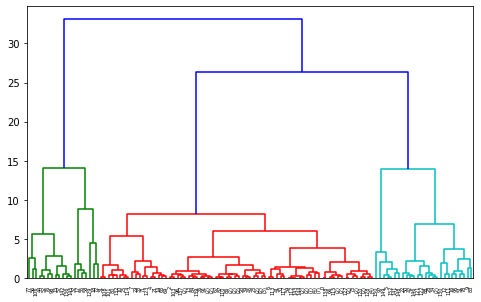

In [139]:
choice='PCA'

document_vectors, vectorizer, labels = vectorize('Industries', min_df=20)
vecs, labels = obtain_word_embeddings(document_vectors, vectorizer)
X = dimensionality_reduction(vecs, choice=choice, n_components=2)

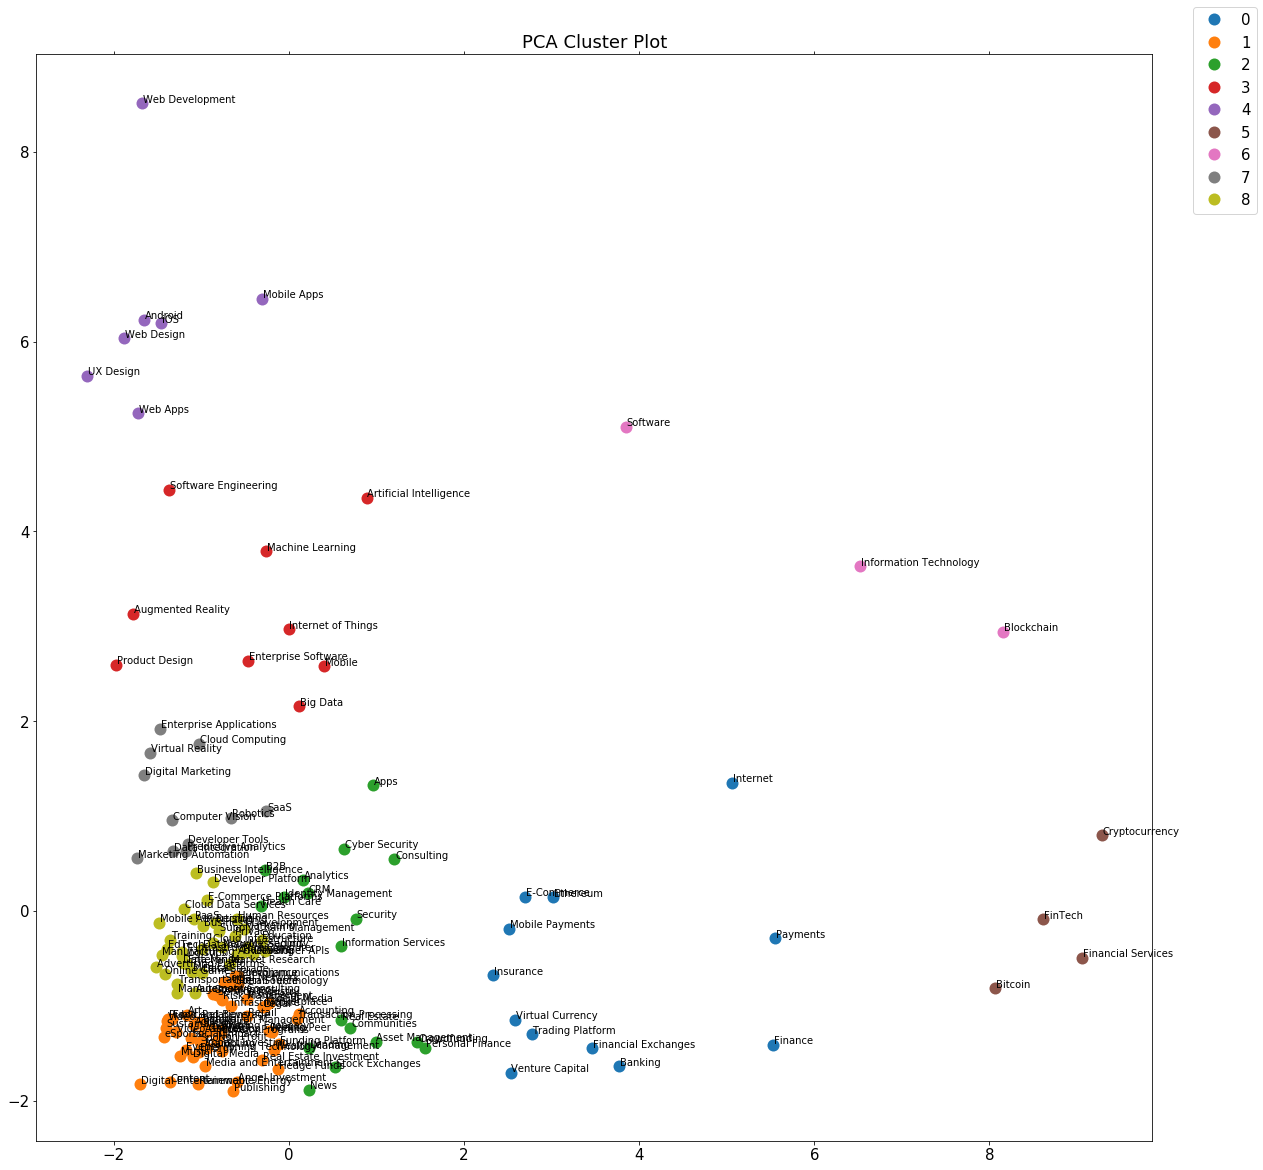

In [140]:
clusters = cluster(X, 9, labels, choice + ' Cluster Plot')

## Industries (TSNE) 

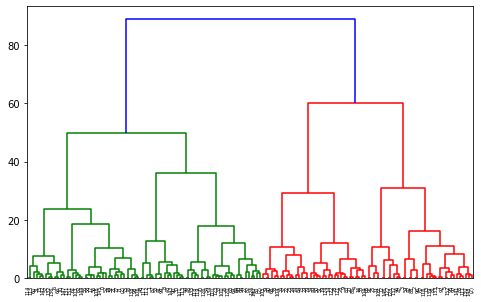

In [178]:
choice='TSNE'

document_vectors, vectorizer, labels = vectorize('Industries', min_df=20)
vecs, labels = obtain_word_embeddings(document_vectors, vectorizer)
X = dimensionality_reduction(vecs, choice=choice, n_components=2)

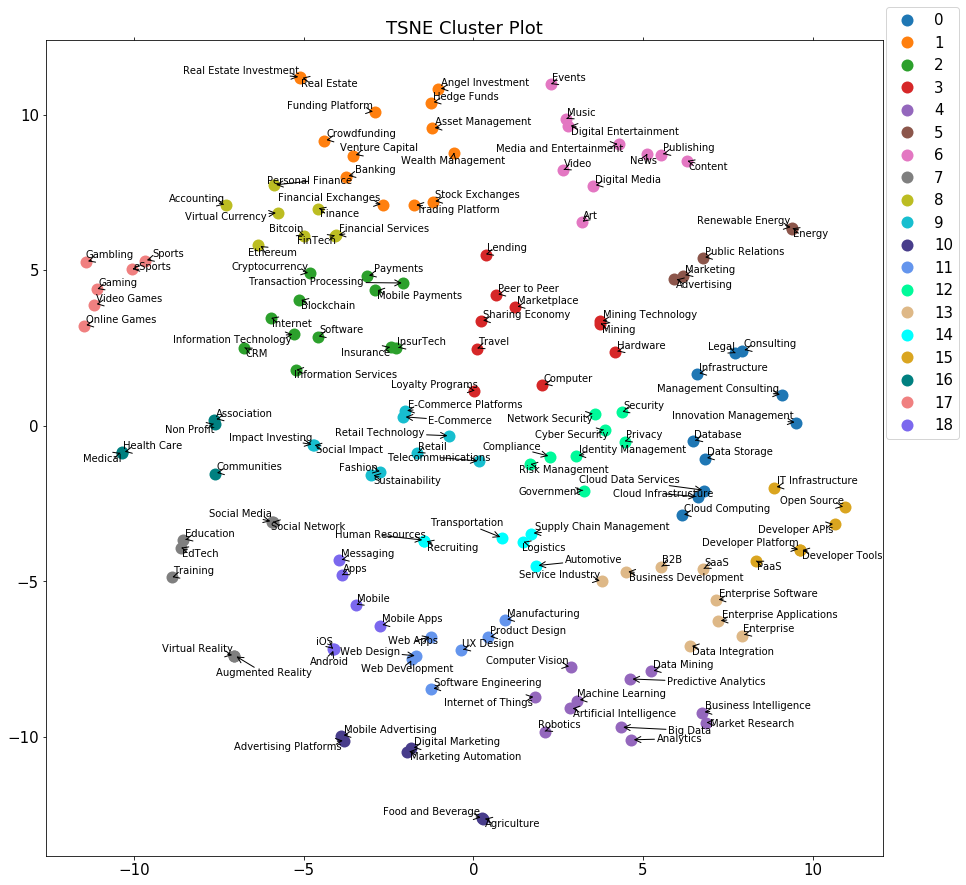

In [180]:
clusters = cluster(X, 19, labels, choice + ' Cluster Plot', width=15, height=15, no_overlap=True)

For less popular industries (setting max_df to a low number):

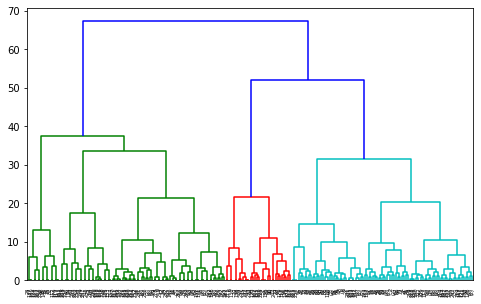

In [174]:
choice='TSNE'

document_vectors, vectorizer, labels = vectorize('Industries', max_df=5)
vecs, labels = obtain_word_embeddings(document_vectors, vectorizer)
X = dimensionality_reduction(vecs, choice=choice, n_components=2)

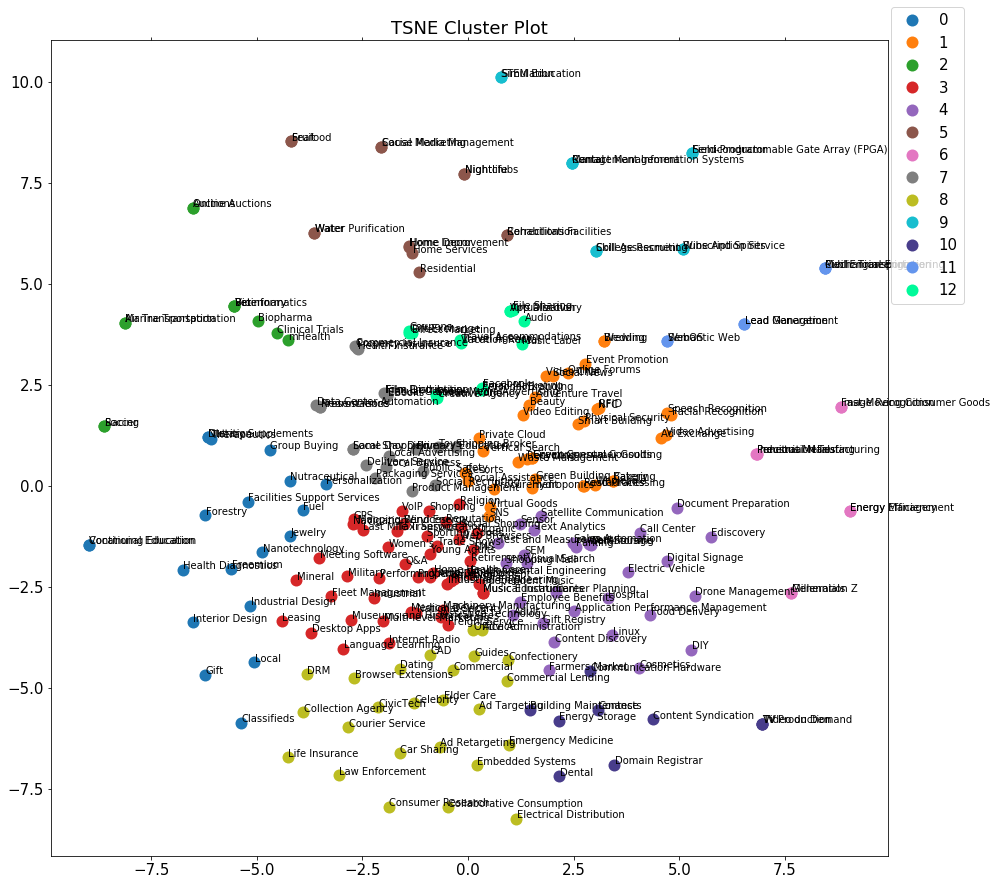

In [176]:
clusters = cluster(X, 13, labels, choice + ' Cluster Plot', width=15, height=15, no_overlap=False)

## Industry Groups (PCA)

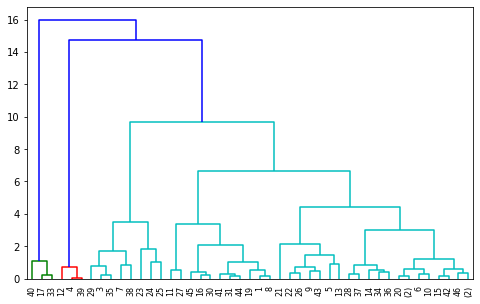

In [143]:
choice='PCA'

document_vectors, vectorizer, labels = vectorize('Industry Groups')
vecs, labels = obtain_word_embeddings(document_vectors, vectorizer)
X = dimensionality_reduction(vecs, choice=choice)

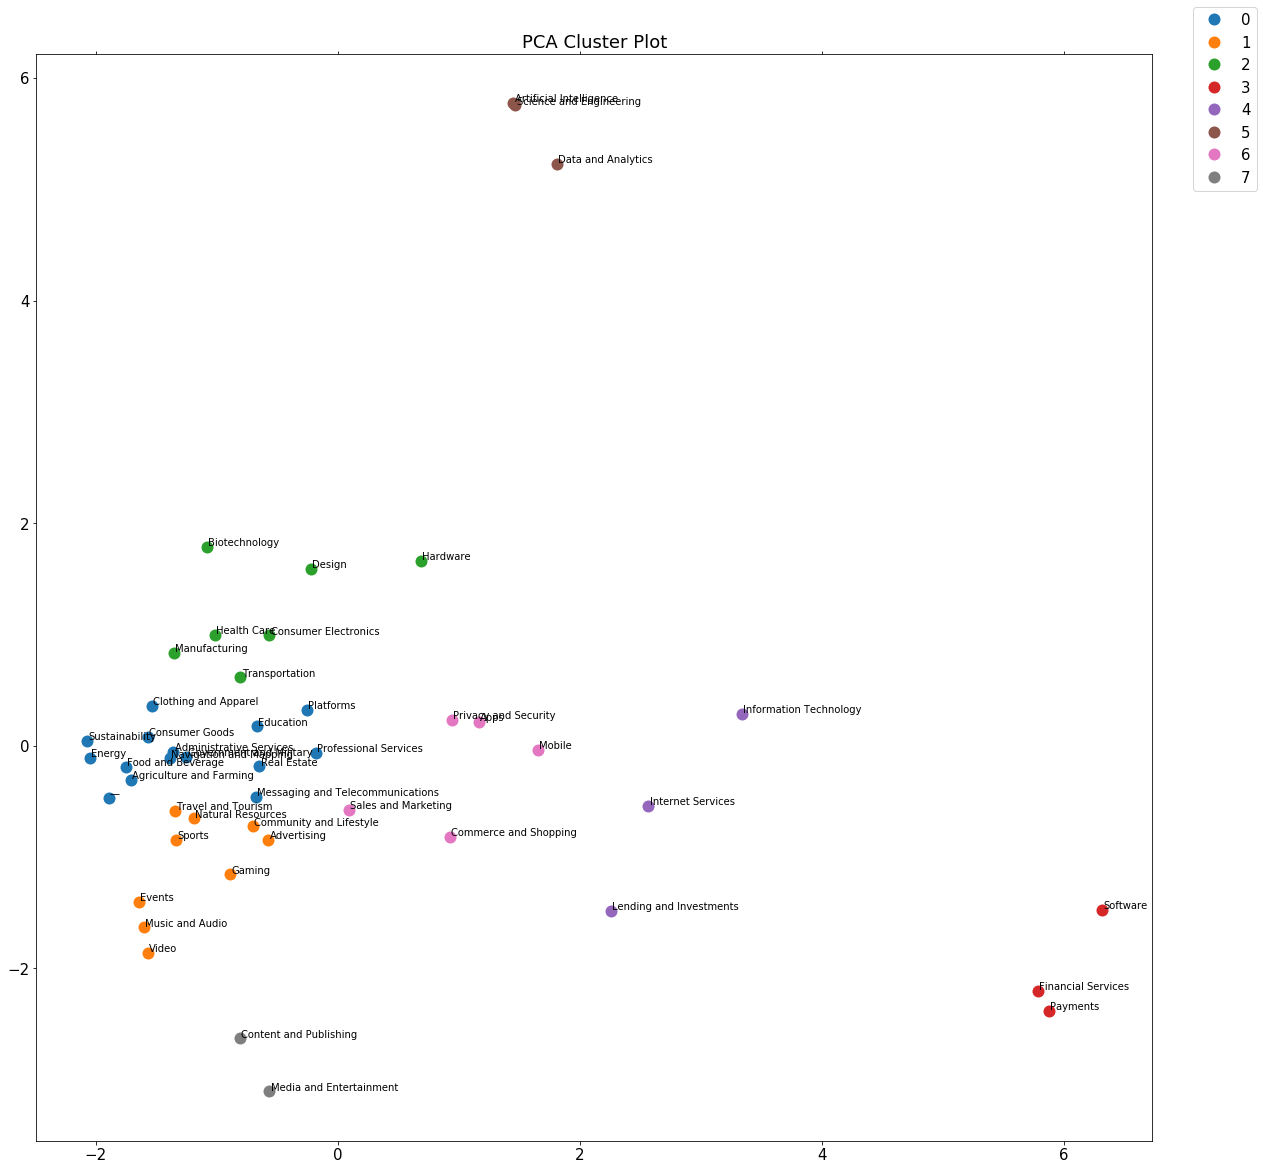

In [145]:
clusters = cluster(X, 8, labels, choice + ' Cluster Plot')

## Industry Groups (TSNE)

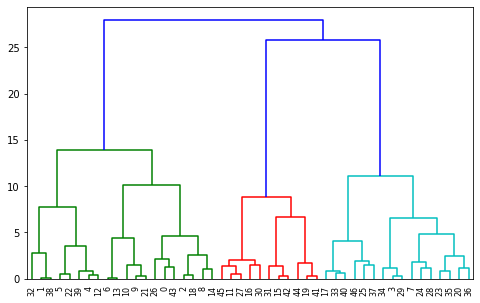

In [146]:
choice='TSNE'

document_vectors, vectorizer, labels = vectorize('Industry Groups')
vecs, labels = obtain_word_embeddings(document_vectors, vectorizer)
X = dimensionality_reduction(vecs, choice=choice)

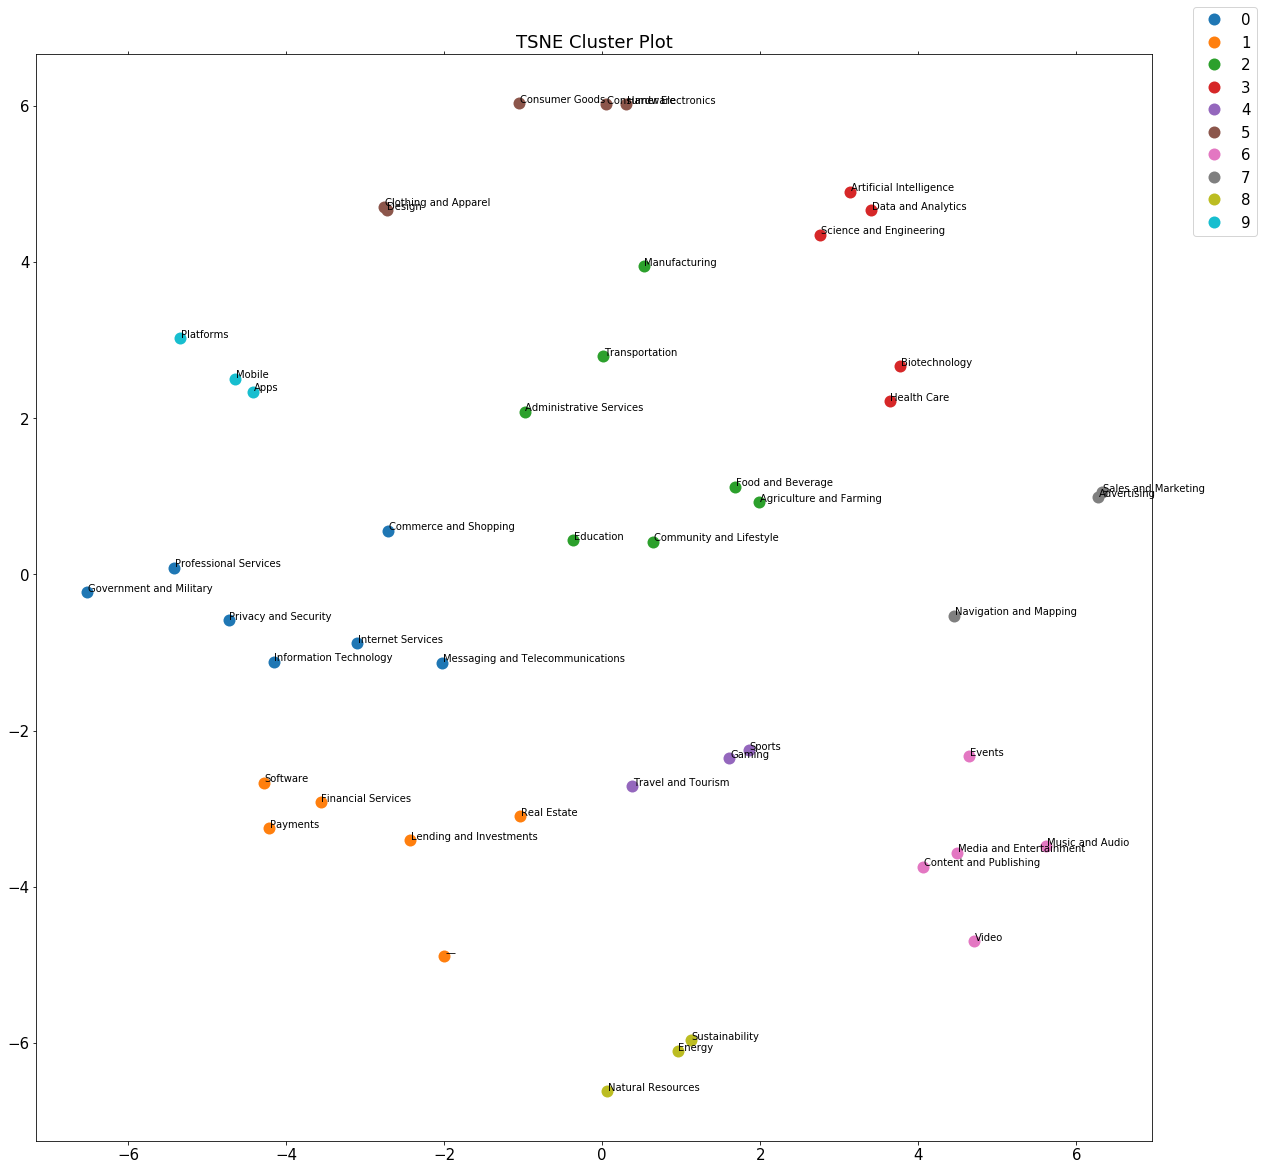

In [147]:
clusters = cluster(X, 10, labels, choice + ' Cluster Plot')

## Companies by Industry (PCA)

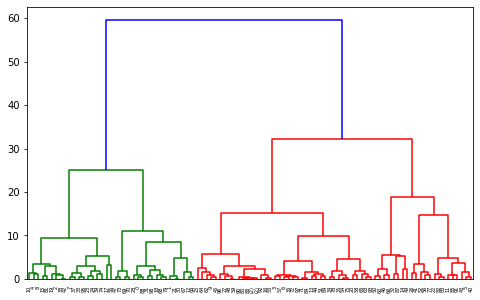

In [262]:
choice='PCA'

document_vectors, vectorizer, labels = vectorize('Industries', chosen_indexes=range(100))
X = dimensionality_reduction(document_vectors, choice=choice)

Cluster 0
Blockchain, Bitcoin, Cryptocurrency, Software, Publishing, Marketplace, SaaS, Media and Entertainment, Cyber Security, FinTech, Internet, iOS, Android, Ethereum, Apps, Virtual Currency, Financial Exchanges

Cluster 1
Bitcoin, Cryptocurrency, FinTech, Financial Exchanges, Finance, Blockchain, Ethereum, Payments, Virtual Currency, Financial Services, Banking, Internet, Trading Platform, Personal Finance, E-Commerce, Information Technology

Cluster 2
Information Technology, Internet, Bitcoin, Cryptocurrency, Blockchain, FinTech, Software, Accounting, Computer, Virtual Currency, Information Services

Cluster 3
Blockchain, E-Commerce, Travel, Messaging, Mobile, Tourism, Cloud Data Services, Cyber Security, Developer APIs, Enterprise Software, Insurance, Artificial Intelligence, Art, Big Data, Internet of Things, Enterprise Applications, Data Visualization, Guides, Collaborative Consumption, Collaboration, Digital Entertainment, eSports, Sports, Cloud Infrastructure, Affiliate Mark

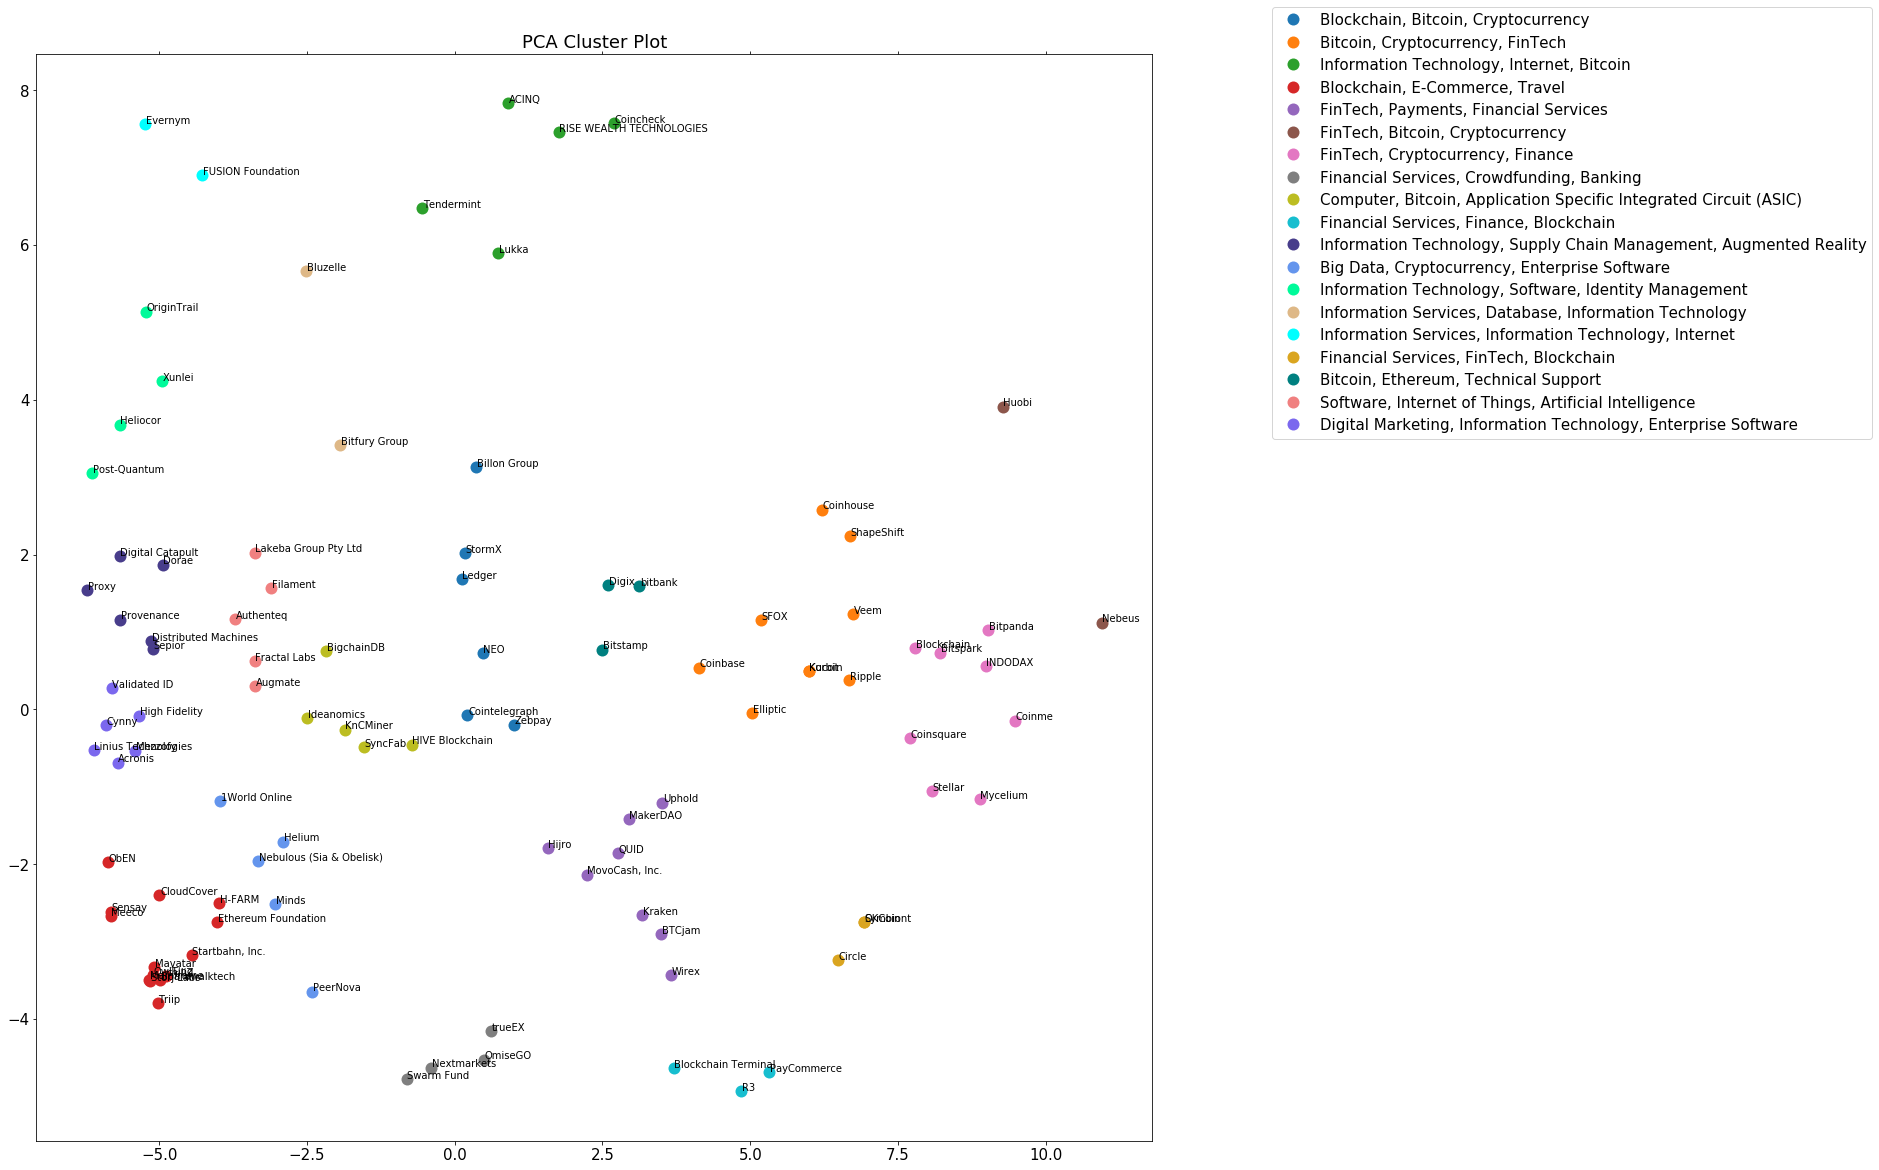

In [263]:
clusters = cluster(X, 19, labels, choice + ' Cluster Plot', label_clusters=True)

In [264]:
print(df[df['Organization Name'] == 'Hijro']['Industries'].tolist())
print(df[df['Organization Name'] == 'QUID']['Industries'].tolist())
print(df[df['Organization Name'] == 'MovoCash, Inc.']['Industries'].tolist())

['Blockchain, Enterprise Software, FinTech, Payments']
['Blockchain, Cloud Computing, Finance, FinTech, Payments']
['Blockchain, Cryptocurrency, Finance, FinTech, Millennials, Mobile Apps, Mobile Payments, Payments']


## Companies by Industry (TSNE)

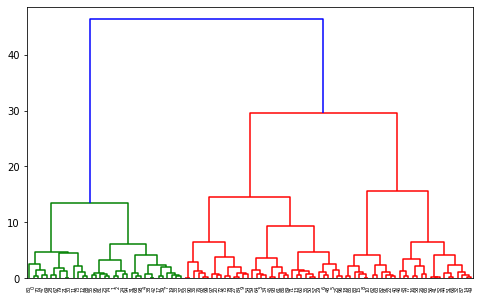

In [265]:
choice='TSNE'

document_vectors, vectorizer, labels = vectorize('Industries', chosen_indexes=range(100))
X = dimensionality_reduction(document_vectors, choice=choice)

Cluster 0
Financial Services, FinTech, Cryptocurrency, Payments, Bitcoin, Blockchain, Finance, Banking, Trading Platform, Financial Exchanges, Non Profit, Internet, Personal Finance, Information Technology

Cluster 1
E-Commerce, Travel, Tourism, Art, Blockchain, Guides, Mobile, Affiliate Marketing, Direct Marketing, Coupons, Advertising Platforms, Retail Technology, PaaS, Fashion, Food and Beverage, Retail, Digital Marketing, Big Data, B2B, SaaS, Internet of Things, Information Technology, FinTech

Cluster 2
Information Services, Information Technology, Supply Chain Management, Blockchain, Database, Internet, Social Impact, Software, Retail Technology, Bitcoin, Mining, Data Center, Mining Technology, SaaS, Hardware, FinTech

Cluster 3
Cyber Security, Privacy, Cloud Infrastructure, Cloud Data Services, Insurance, Blockchain, SaaS, Collaborative Consumption, Big Data, Virtualization, File Sharing, Data Integration, Private Cloud, Developer APIs, Cloud Computing, Mobile Apps, Bitcoin, Cry

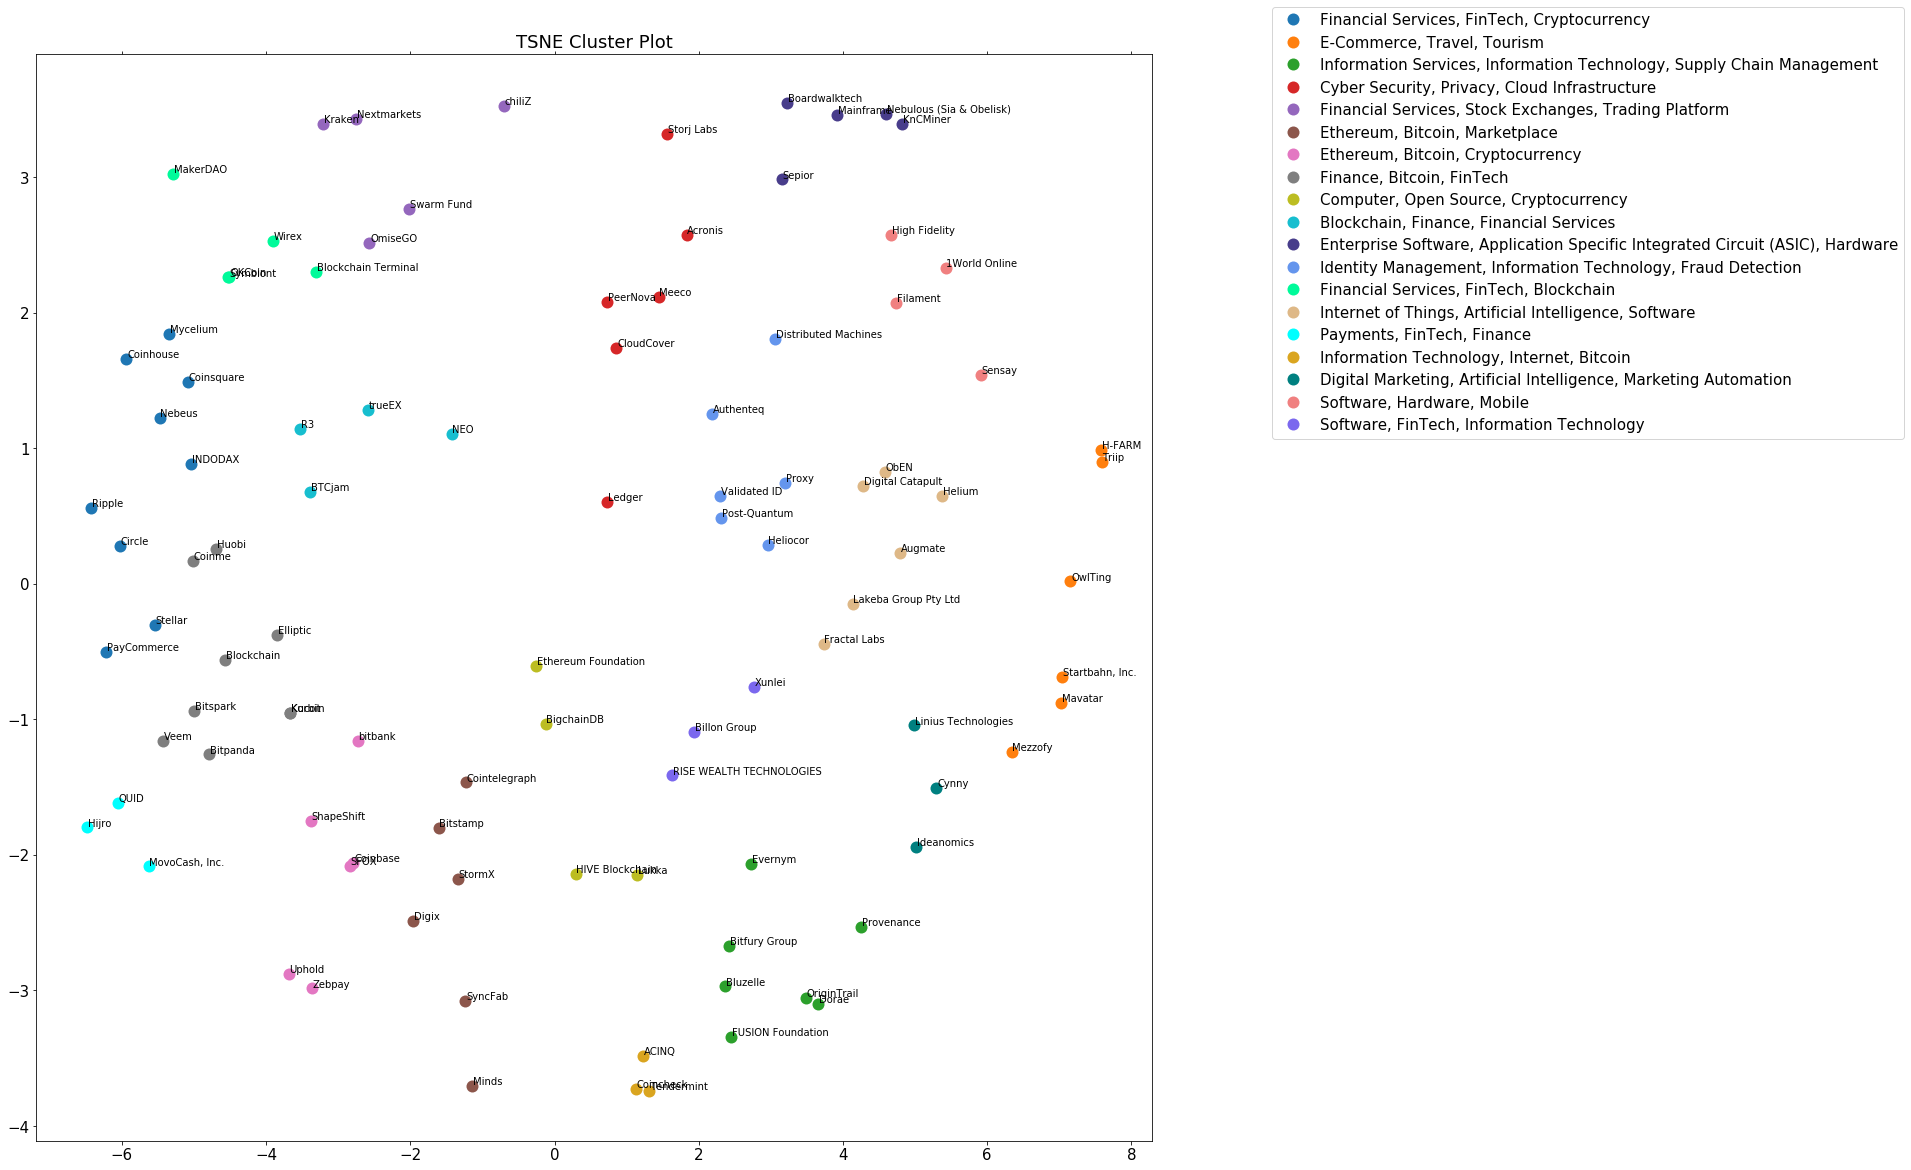

In [266]:
clusters = cluster(X, 19, labels, choice + ' Cluster Plot', label_clusters=True)

## See Industry Words in Each Cluster

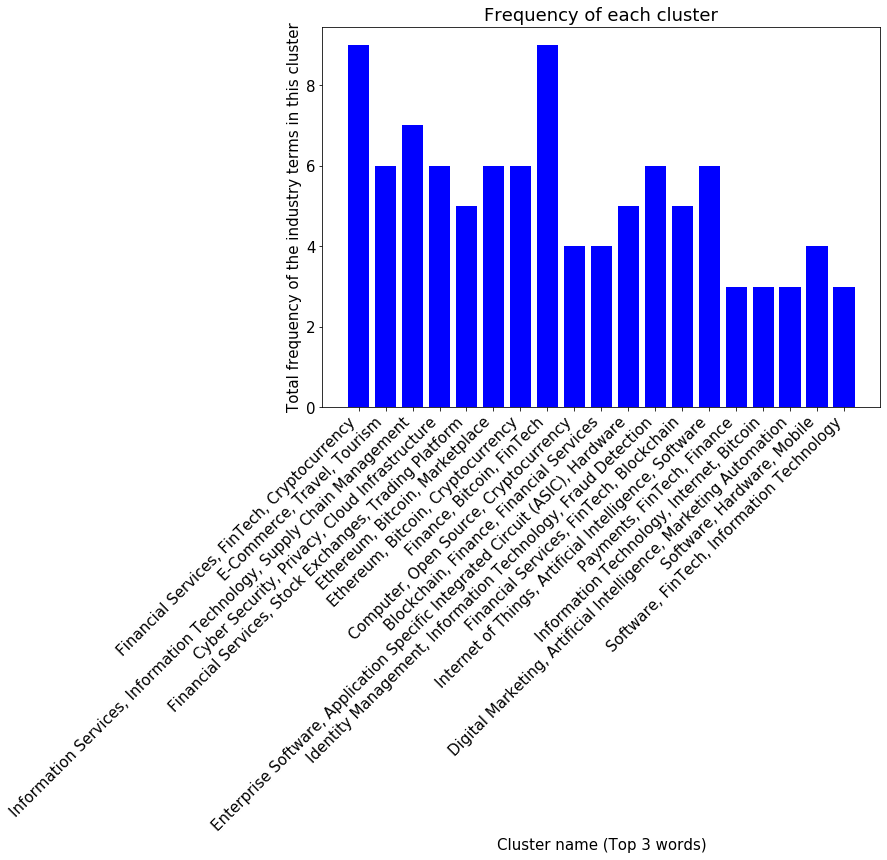

In [269]:
get_industry_counts_in_clusters(document_vectors, clusters, vectorizer.get_feature_names(), 20, width=10, height=7)